<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/image_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
imagesfilenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")

In [8]:
os.chdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")

In [29]:
len(imagesfilenames)

1054

In [33]:
light = glob.glob('*light*.tif')

In [35]:
light

['PaperedControl20d_light.tif',
 'PaperedControl21v_light.tif',
 'PaperedControl21d_light.tif',
 'PaperedControl23v_light.tif',
 'PaperedControl23d_light.tif',
 'PaperedControl24d_light.tif',
 'PaperedControl26v_light.tif',
 'PaperedControl26d_light.tif',
 'PaperedControl34v_light.tif',
 'PaperedControl34d_light.tif',
 'PaperedControl37v2_light.tif',
 'PaperedControl41v_light.tif',
 'PaperedControl41d_light.tif',
 'PaperedControl47d_light.tif',
 'PaperedControl53v_light.tif',
 'PaperedControl59d_light.tif',
 'PaperedControl60v_light.tif',
 'PaperedControl62v_light.tif',
 'PaperedControl75v_light.tif',
 'PaperedControl75d_light.tif',
 'PaperedControl76v_light.tif',
 'PaperedControl76d_light.tif',
 'PaperedTransparent3v_light.tif',
 'PaperedTransparent3d_light.tif',
 'PaperedTransparent6v_light.tif',
 'PaperedTransparent6d_light.tif',
 'PaperedTransparent24d_light.tif',
 'PaperedTransparent25v_light.tif',
 'PaperedTransparent25d_light.tif',
 'PaperedTransparent51v_light.tif',
 'PaperedTr

# Build data

In [36]:
def group_data():
  PaperedControl = glob.glob('PaperedControl*.tif')
  PaperedTransparent = glob.glob('PaperedTransparent*.tif')
  # labeled?
  PinkPapierMache = [f for f in glob.glob('PinkPapierMache*.tif') if "Mixed" not in f]
  NoPaperedGreen = glob.glob('NoPaperedGreen*.tif')
  # labeled?
  PinkPaintedPaper = glob.glob('PinkPaintedPaper*.tif')
  NoPaperedMixed = glob.glob('NoPaperedMixed*.tif')
  PaperedMixed = glob.glob('PaperedMixed*.tif')
  #labeled?
  PinkPapierMacheMixed = glob.glob('PinkPapierMacheMixed*.tif')
  # Not labeled
  Trap = glob.glob('Trap*.tif')
  return PaperedControl, PaperedTransparent, PinkPapierMache, NoPaperedGreen, PinkPaintedPaper, NoPaperedMixed, PaperedMixed, PinkPapierMacheMixed, Trap

def build_dataframe():
  PaperedControl, PaperedTransparent, PinkPapierMache, NoPaperedGreen, PinkPaintedPaper, NoPaperedMixed, PaperedMixed, PinkPapierMacheMixed, Trap = group_data()
  marked = PaperedControl +PaperedTransparent + PaperedMixed;
  marked = [f for f in marked if "light" not in f]
  unmarked = NoPaperedGreen + NoPaperedMixed
  unmarked = [f for f in unmarked if "light" not in f]


  df = pd.DataFrame({
    "filename": marked + unmarked ,
    "category": ['Marked']*len(marked) + ['Unmarked']*len(unmarked) 
  })
  return df

In [37]:
PaperedControl, PaperedTransparent, PinkPapierMache, NoPaperedGreen, PinkPaintedPaper, NoPaperedMixed, PaperedMixed, PinkPapierMacheMixed, Trap = group_data()

In [24]:
len(PinkPaintedPaper) + len(PinkPapierMache) + len(PinkPapierMacheMixed) + len(Trap)

252

In [ ]:
len(PaperedControl) + len(PaperedTransparent) + + len(PaperedMixed) + \
len(NoPaperedGreen) + len(NoPaperedMixed)+ len(PinkPaintedPaper)  + len(PinkPapierMache)    + len(Trap) + len(PinkPapierMacheMixed)

1053

In [32]:
len(imagesfilenames)-1

1053

In [39]:
df=build_dataframe()

In [44]:
df.groupby('category').count()

,filename
category,
Marked,482
Unmarked,278


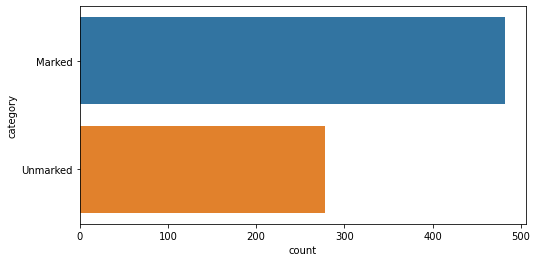

In [40]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

# Split into train and test

In [13]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [39]:
train_df

,filename,category
0,NoPaperedGreen29d.tif,Unmarked
1,NoPaperedGreen37d.tif,Unmarked
2,PaperedMixed36d.tif,Marked
3,PinkPapierMache9v.tif,Marked
4,NoPaperedMixed29d.tif,Unmarked
...,...,...
775,PaperedControl79d.tif,Marked
776,NoPaperedMixed21d.tif,Unmarked
777,NoPaperedGreen34d.tif,Unmarked
778,PinkPapierMache30d.tif,Marked


# Keras preprocessing functions

In [ ]:
def visualize_img(img):
    image = np.array(img)
    return image / 255

In [44]:
IMG_SIZE = (180,180)
BATCH_SIZE = 32

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=visualize_img,
    brightness_range=[0.7,2.0],
                    )

In [ ]:
sample_df=train_df.iloc[[8]]

In [ ]:
batches = datagen.flow_from_dataframe(sample_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",

                             x_col = 'filename',
                             y_col = 'category',
                             target_size = IMG_SIZE,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             
                            )

Found 1 validated image filenames belonging to 1 classes.


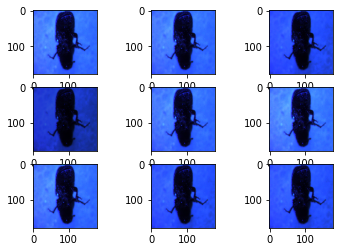

In [ ]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	xbatch, ybatch = next(batches)
	# convert to unsigned integers for viewing
	image = xbatch[0]
	# plot raw pixel data
	plt.imshow(image)

In [ ]:
datagen_center = ImageDataGenerator(
    preprocessing_function=visualize_img,
    # zoom_range = [0.5, 1.0],
    brightness_range=[0.7,3.0],
    featurewise_center=True
                    )

In [ ]:
batches2 = datagen_center.flow_from_dataframe(sample_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",

                             x_col = 'filename',
                             y_col = 'category',
                             target_size = IMG_SIZE,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             
                            )

Found 1 validated image filenames belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


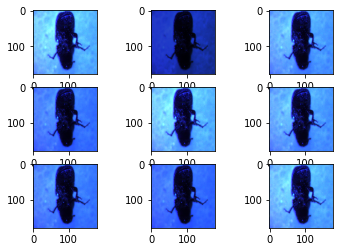

In [ ]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	xbatch, ybatch = next(batches2)
	# convert to unsigned integers for viewing
	image = xbatch[0]
	# plot raw pixel data
	plt.imshow(image)

# Thresholding

In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [16]:
IMG_SIZE = (180,180)

In [4]:
def threscrop(img):
  # img = keras.preprocessing.image.img_to_array(image)
  grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
  # grayscale = grayscale.reshape(grayscale.shape + (1,))
  blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
  # blur = blur.reshape(blur.shape + (1,))
  retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # thresh = thresh.reshape(thresh.shape + (1,))

 

  # detect edges and crop the image
  canny = cv2.Canny(thresh.astype(np.uint8), 50, 200)
  pts = np.argwhere(canny > 0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  cropped_img = thresh[y1:y2, x1:x2]
  # out = keras.preprocessing.image.img_to_array(cropped_img)
  cropped_img = cv2.resize(cropped_img, IMG_SIZE)
 
  cropped_img = cropped_img.reshape(cropped_img.shape + (1,))


  return cropped_img


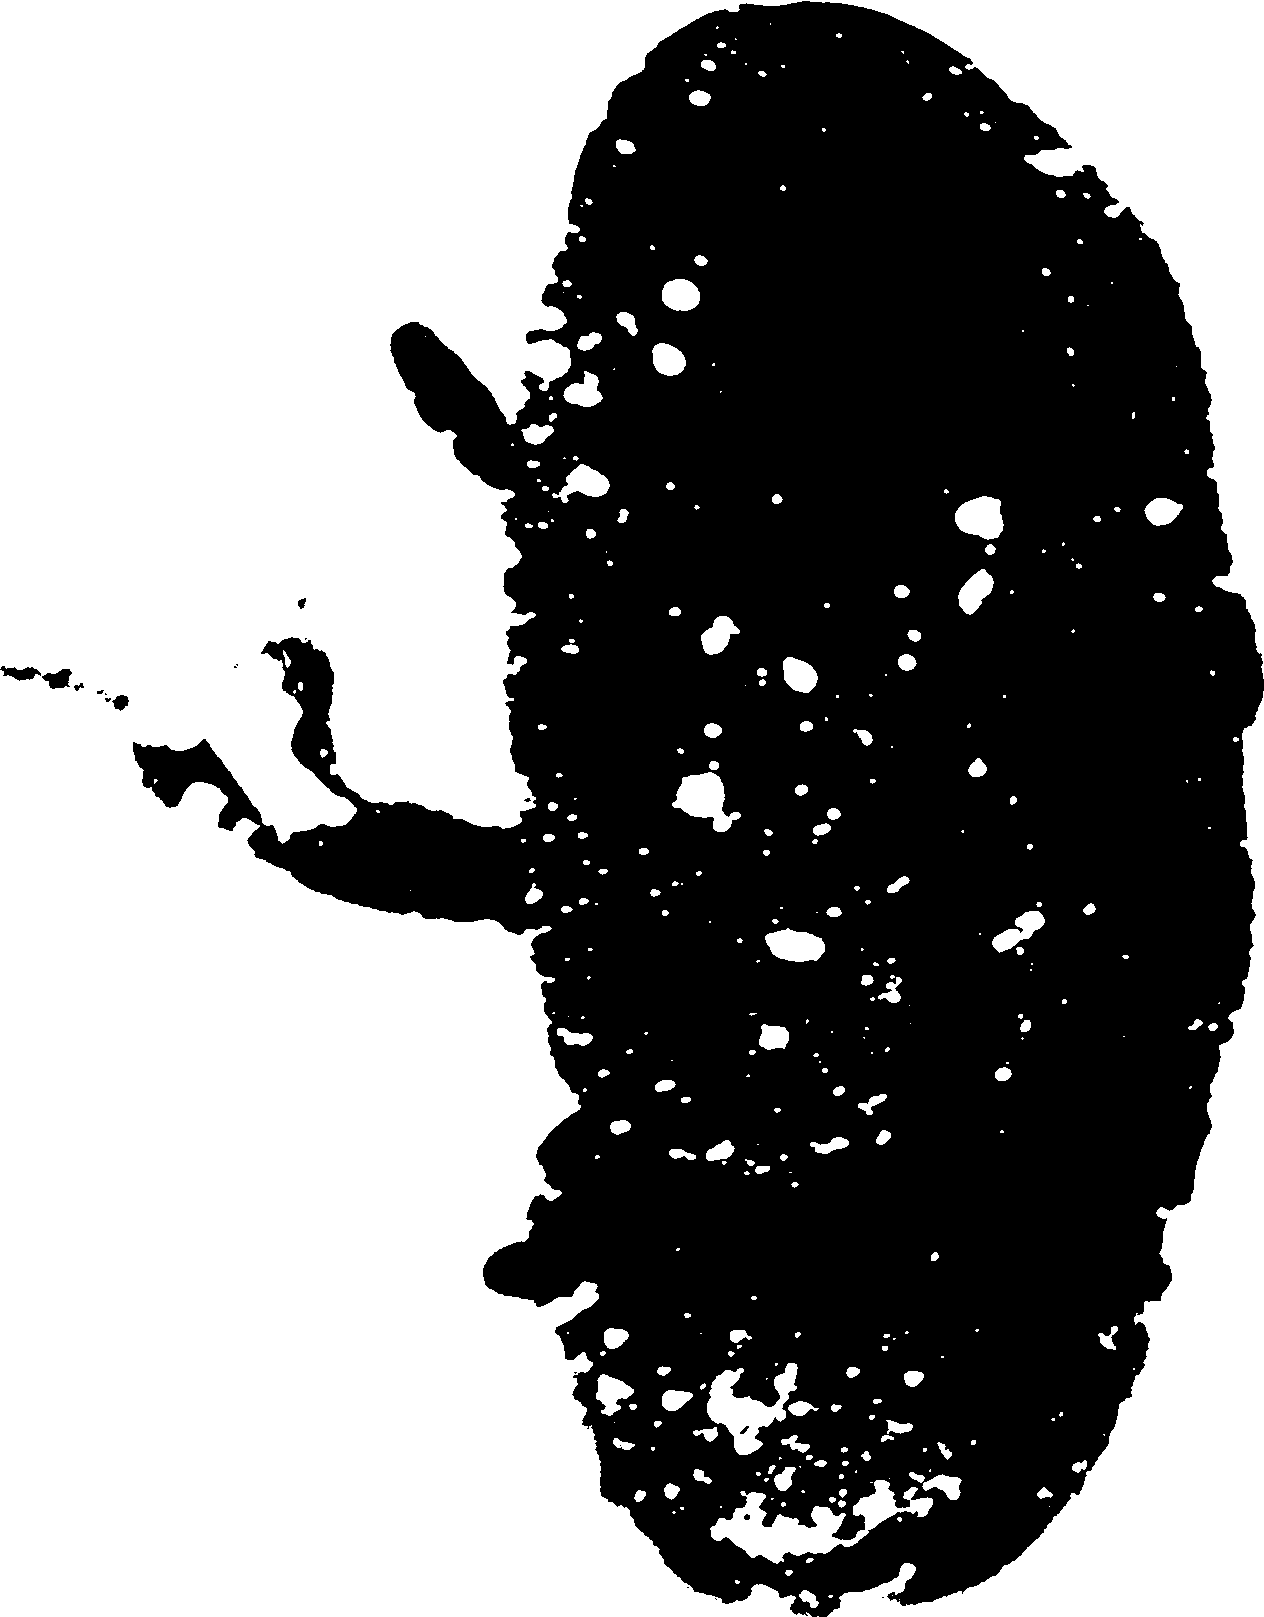

In [641]:
image=cv2.imread('PaperedTransparent6d.tif')
cv2_imshow(threscrop(image))

In [24]:
datagen = ImageDataGenerator(
   
    preprocessing_function=threscrop
                    )

In [25]:
sample_df = pd.DataFrame({
    "filename": ['PaperedTransparent6d.tif'],
    "category": ['Marked']
  })

In [26]:
# sample_df=train_df.iloc[[8]]
batches = datagen.flow_from_dataframe(sample_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",

                             x_col = 'filename',
                             y_col = 'category',
                             target_size = IMG_SIZE,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             
                            )

Found 1 validated image filenames belonging to 1 classes.


In [27]:
xb, yb=next(batches)

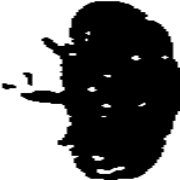

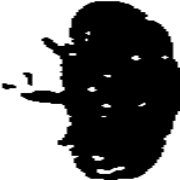

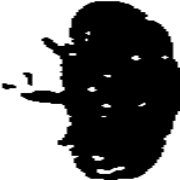

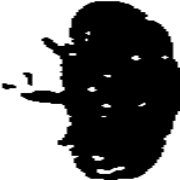

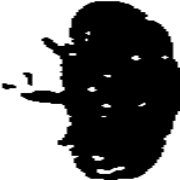

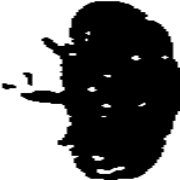

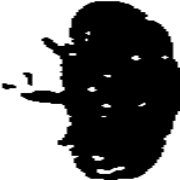

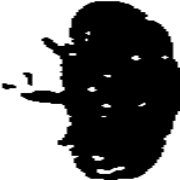

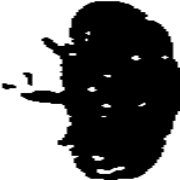

In [28]:
for i in range(9):
	# define subplot
	
	# generate batch of images
	xbatch, ybatch = next(batches)
	# convert to unsigned integers for viewing
	image = xbatch[0]
	# plot raw pixel data
	cv2_imshow(image)